# DOE 本番解析用 (base)

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイル一覧の取得

In [4]:
name_doe = "doe-6a"  # 実験計画名（フォルダ名）
name_code = "7011"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{8})\..+")
if m := pattern_date.match(file_last):
    date_str = m.group(1)  # 保存ファイル目に付与する日付
else:
    date_str = "00000000"
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_2025

## CSV ファイルの読み込み、連結

In [5]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)
df.to_pickle(f"{name_doe}_{name_code}.pkl")


日毎のシミュレーション結果例（連結前）
                    file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0    ticks_20250819.xlsx  7011     30           30          300   42.0
1    ticks_20250819.xlsx  7011     18           45          300   36.0
2    ticks_20250819.xlsx  7011     18           60          300   74.0
3    ticks_20250819.xlsx  7011     12           75          300   96.0
4    ticks_20250819.xlsx  7011      6           90          300   37.0
..                   ...   ...    ...          ...          ...    ...
116  ticks_20250819.xlsx  7011      8          120          900   36.0
117  ticks_20250819.xlsx  7011      8          135          900   55.0
118  ticks_20250819.xlsx  7011      6          150          900   28.0
119  ticks_20250819.xlsx  7011      8          165          900   35.0
120  ticks_20250819.xlsx  7011      4          180          900  -17.0

[121 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
0  

## サマリ統計の算出

In [6]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)
html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_summary.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade      total
0             30          300  41.666667  -1.511905
1             45          300  32.476190  -2.619048
2             60          300  29.309524  -0.869048
3             75          300  25.547619   1.630952
4             90          300  23.571429   1.976190
..           ...          ...        ...        ...
116          120          900  11.714286  12.857143
117          135          900  11.261905  12.357143
118          150          900  10.357143  10.940476
119          165          900   9.666667   6.690476
120          180          900   8.785714   3.821429

[121 rows x 4 columns]


## 平均収益の集計

In [7]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 平均収益の算出

In [8]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    if i == 0:
        print("日毎のシミュレーション結果 (total のみ）例（連結前の Series）")
        print(ser)
    list_ser.append(ser)
# pd.Series を結合して転置
df_mean = pd.concat(list_ser, axis=1).T
print("\ndf_mean: まだ平均値ではなく、その日の収益（Series を連結）")
print(df_mean)

# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均収益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均収益（逆ソート後）")
print(ser_ranking)

日毎のシミュレーション結果 (total のみ）例（連結前の Series）
0      42.0
1      36.0
2      74.0
3      96.0
4      37.0
       ... 
116    36.0
117    55.0
118    28.0
119    35.0
120   -17.0
Name: 2025-08-19 00:00:00, Length: 121, dtype: float64

df_mean: まだ平均値ではなく、その日の収益（Series を連結）
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  42.0  36.0  74.0  96.0  37.0  85.0  76.0  87.0  43.0  87.0  ...   
2025-08-20  15.0 -15.0  -7.0  42.0  53.0   5.0   0.0  31.0  46.0  -2.0  ...   
2025-08-21 -46.0 -52.0   9.0   1.0  13.0  24.0  35.0  32.0   9.0  -6.0  ...   
2025-08-22 -20.0   3.0  -8.0 -16.0   3.0  -9.0  -8.0  -9.0 -11.0 -11.0  ...   
2025-08-25   7.0  15.0   6.0   7.0  11.0  11.0  -7.0 -14.0 -10.0  -9.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-15  36.0  27.0  -3.0   3.0  -5.0 -16.0  -2.0  -6.0 -25.0   9.0  ...   
2025-12-16  15.0 -11.0  -2.0  18.0  14.0  59.0  58.0  58.0  46.0  20.0  ...   
2025-12-17  -6.0  10.0  

### 検算

In [9]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング

In [10]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions]
print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の平均収益が負になっている実験条件
negative_condition = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_condition]
print("---\n[Bad Conditions]")
print(df_negative)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_negative.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2      trade      total
46            60          540  21.761905  14.797619
47            75          540  18.785714  14.202381
68            60          660  20.047619  13.261905
49           105          540  16.071429  13.095238
116          120          900  11.714286  12.857143
117          135          900  11.261905  12.357143
79            60          720  19.642857  12.345238
64           165          600  11.619048  12.261905
58            75          600  17.285714  11.500000
61           120          600  13.904762  11.476190
---
[Bad Conditions]
   PERIOD_MA_1  PERIOD_MA_2      trade     total
5          105          300  23.190476 -0.285714
2           60          300  29.309524 -0.869048
0           30          300  41.666667 -1.511905
1           45          300  32.476190 -2.619048


## 実験条件毎の収益トレンド

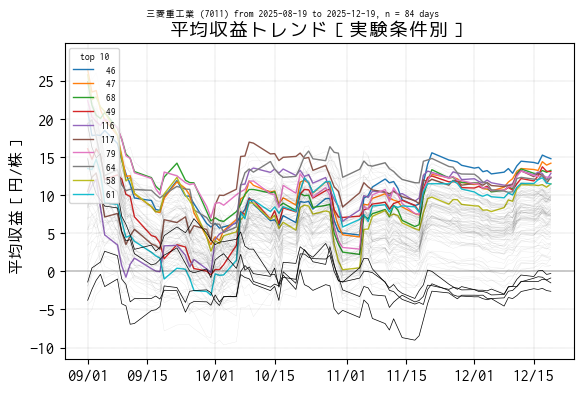

In [11]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_condition:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均収益［円/株］")
ax.set_title("平均収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc='upper left', fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_mean_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

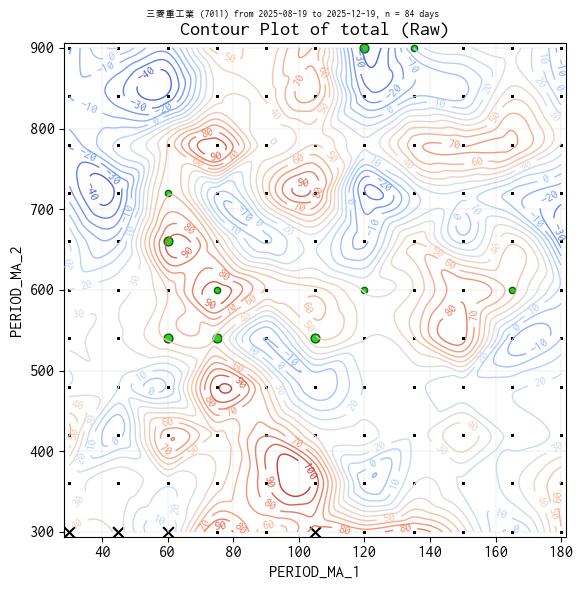

In [12]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
ax.clabel(cont, inline=True, fontsize=9)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
# ２つに分ける
n = int(len(df_best) / 2)
df_best_1 = df_best[:n]
df_best_2 = df_best[n:]
ax.scatter(
    df_best_1[col_x],
    df_best_1[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    df_best_2[col_x],
    df_best_2[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=20,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

output = os.path.join(
    "..", "output", name_doe, f"{date_str}_{name_code}_raw_contour_{target}.png"
)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

最高収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
6382  ticks_20251105.xlsx  7011     28           60          780  313.0

最低収益
                     file  code  trade  PERIOD_MA_1  PERIOD_MA_2  total
6080  ticks_20251031.xlsx  7011     32          150          420 -208.0



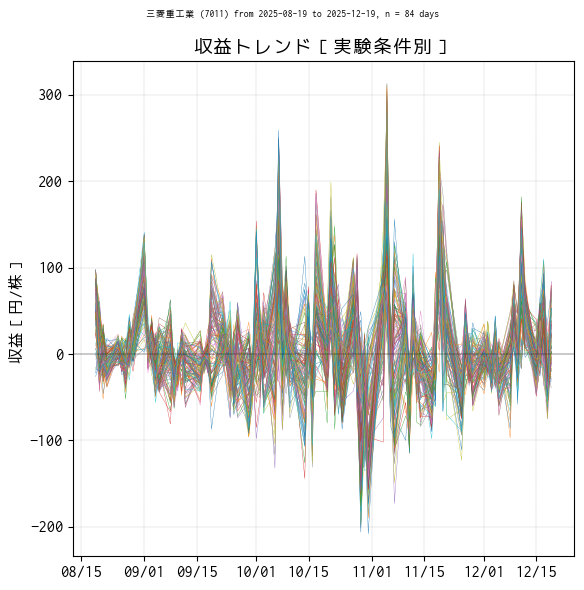

In [13]:
# 実験水準
list_factor_1 = sorted(list(set(df[factor_cols[0]])))
list_factor_2 = sorted(list(set(df[factor_cols[1]])))
profit_max = -np.inf
profit_min = +np.inf
# ---------------------------------------------------------
# 実験条件毎の収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

for factor_1 in list_factor_1:
    for factor_2 in list_factor_2:
        df_profit = df[
            (df[factor_cols[0]] == factor_1) & (df[factor_cols[1]] == factor_2)
        ]
        df_profit.index = [get_date_from_file(file) for file in df_profit["file"]]

        profit_max_local = df_profit["total"].max()
        if profit_max < profit_max_local:
            profit_max = profit_max_local

        profit_min_local = df_profit["total"].min()
        if profit_min_local < profit_min:
            profit_min = profit_min_local
        n_cond = int(
            df_summary[
                (df_summary[factor_cols[0]] == factor_1)
                & (df_summary[factor_cols[1]] == factor_2)
            ].index[0]
        )
        ax.plot(df_profit["total"], linewidth=0.25, label=f"{n_cond}")

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("収益［円/株］")
ax.set_title("収益トレンド［実験条件別］")
# 凡例
# lg = ax.legend(fontsize=7)
# lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

print("最高収益")
print(df[df["total"] == profit_max])
print("\n最低収益")
print(df[df["total"] == profit_min])
print()

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
# plt.savefig(output)
plt.show()

## メディアン収益の算出

In [14]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    if i == 0:
        print("日毎のシミュレーション結果 (total のみ）例（連結前の Series）")
        print(ser)
    list_ser.append(ser)
# pd.Series を結合して転置
df_median = pd.concat(list_ser, axis=1).T
print("\ndf_median: まだメディアンではなく、その日の収益（Series を連結）")
print(df_median)

# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

日毎のシミュレーション結果 (total のみ）例（連結前の Series）
0      42.0
1      36.0
2      74.0
3      96.0
4      37.0
       ... 
116    36.0
117    55.0
118    28.0
119    35.0
120   -17.0
Name: 2025-08-19 00:00:00, Length: 121, dtype: float64

df_median: まだメディアンではなく、その日の収益（Series を連結）
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  42.0  36.0  74.0  96.0  37.0  85.0  76.0  87.0  43.0  87.0  ...   
2025-08-20  15.0 -15.0  -7.0  42.0  53.0   5.0   0.0  31.0  46.0  -2.0  ...   
2025-08-21 -46.0 -52.0   9.0   1.0  13.0  24.0  35.0  32.0   9.0  -6.0  ...   
2025-08-22 -20.0   3.0  -8.0 -16.0   3.0  -9.0  -8.0  -9.0 -11.0 -11.0  ...   
2025-08-25   7.0  15.0   6.0   7.0  11.0  11.0  -7.0 -14.0 -10.0  -9.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-15  36.0  27.0  -3.0   3.0  -5.0 -16.0  -2.0  -6.0 -25.0   9.0  ...   
2025-12-16  15.0 -11.0  -2.0  18.0  14.0  59.0  58.0  58.0  46.0  20.0  ...   
2025-12-17  -6.0  10

In [15]:
n = len(df_median.index)

In [16]:
df_median[:n].median()

0     -5.0
1     -5.5
2     -3.0
3     -3.5
4     -2.0
      ... 
116    4.5
117    4.5
118    2.0
119    0.0
120   -2.0
Length: 121, dtype: float64

In [17]:
# メディアン収益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン収益を算出")
print(df_median)

# 最終日の平均収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン収益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン収益を算出
             0     1     2     3     4     5     6     7     8     9    ...  \
2025-08-19  42.0  36.0  74.0  96.0  37.0  85.0  76.0  87.0  43.0  87.0  ...   
2025-08-20  28.5  10.5  33.5  69.0  45.0  45.0  38.0  59.0  44.5  42.5  ...   
2025-08-21  15.0 -15.0   9.0  42.0  37.0  24.0  35.0  32.0  43.0  -2.0  ...   
2025-08-22  -2.5  -6.0   1.0  21.5  25.0  14.5  17.5  31.5  26.0  -4.0  ...   
2025-08-25   7.0   3.0   6.0   7.0  13.0  11.0   0.0  31.0   9.0  -6.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025-12-15  -4.5  -4.5  -3.5  -5.0  -2.0  -3.0  -2.5   1.0  -4.0  -1.5  ...   
2025-12-16  -4.0  -5.0  -3.0  -5.0  -1.0  -3.0  -2.0   1.0  -4.0  -1.0  ...   
2025-12-17  -4.5  -4.5  -3.0  -3.5  -2.0  -2.5  -2.5   1.5  -3.0  -0.5  ...   
2025-12-18  -5.0  -5.0  -3.0  -5.0  -3.0  -3.0  -3.0   1.0  -4.0  -1.0  ...   
2025-12-19  -5.0  -5.5  -3.0  -3.5  -2.0  -2.5  -2.5   1.5  -4.0  -1.5  ...   

             

## サマリ統計（メディアン）

In [18]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  trade  total
0             30          300   39.0   -5.0
1             45          300   27.0   -5.5
2             60          300   25.0   -3.0
3             75          300   22.0   -3.5
4             90          300   21.0   -2.0
..           ...          ...    ...    ...
116          120          900   10.0    4.5
117          135          900   10.0    4.5
118          150          900    8.0    2.0
119          165          900    8.0    0.0
120          180          900    8.0   -2.0

[121 rows x 4 columns]


### 検算

In [19]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均収益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [20]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions]
print("---\n[Best Conditions]")
print(df_best)

# HTML 形式で出力
styled = df_best.style.format({"trade": "{:.1f}", "total": "{:.2f}"}).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_best_median.html",
)
with open(output, "w", encoding="utf-8") as f:
    f.write(html)


# 最新の平均収益が負になっている実験条件
negative_condition = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_condition]
print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2  trade  total
33            30          480   28.0    8.0
58            75          600   16.0    7.5
68            60          660   18.0    7.0
112           60          900   16.0    6.5
46            60          540   20.0    6.0
102           75          840   13.0    6.0
30           150          420   14.0    6.0
31           165          420   12.0    6.0
79            60          720   18.0    5.5
49           105          540   14.0    5.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  trade  total
111           45          900   17.0   -0.5
13            60          360   24.0   -0.5
41           150          480   14.0   -0.5
71           105          660   12.0   -0.5
70            90          660   12.0   -0.5
78            45          720   16.0   -0.5
14            75          360   22.0   -1.0
88            30          780   24.0   -1.0
97           165          780    9.0   -1.0
82           105          720   1

## 実験条件毎の収益トレンド（メディアン）

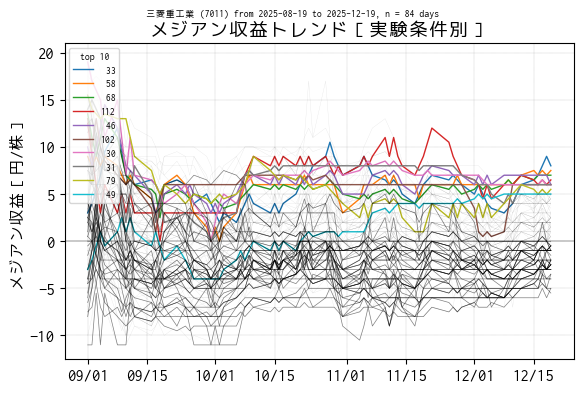

In [21]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_condition:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン収益［円/株］")
ax.set_title("メジアン収益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc='upper left', fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{date_str}_{name_code}_trend_median_profit_{target}.png",
)
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()